In [0]:
from google.colab import drive
drive.mount('/gdrive')
! pip install cmapPy GSVA

In [0]:
# importing packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from cmapPy.pandasGEXpress.parse import parse
import matplotlib.pyplot as plt

import os
import re
from itertools import combinations

In [9]:
#getting data from drive
path = '/gdrive/My Drive/Machine_learning/elucidata/'
os.listdir(path)

['PAAD.gct', 'type1_IFN.txt']

## EDA and Data Cleaning

In [0]:
#reading the data
gctoo_obj = parse(f'{path}PAAD.gct')
df = gctoo_obj.data_df

In [242]:
# looking at the data
df = df.T
print(df.shape)
df.head(2)

(183, 18465)


rid,SLC35E2,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,...,ZP3,ZPBP2,ZPLD1,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aab1-Primary solid Tumor,7.45,6.4,4.7,-1.0,7.5,6.4,14.3,10.6,8.8,1.0,9.4,-1.0,10.2,9.2,4.8,10.2,9.6,11.8,NaN,8.6,8.9,11.3,8.6,7.5,8.1,10.6,10.0,9.4,4.4,5.8,1.8,7.4,1.0,7.8,10.4,9.7,1.0,8.1,7.9,9.3,...,7.7,NaN,3.9,9.4,9.4,5.5,8.1,4.0,7.2,6.9,9.1,1.5,6.0,8.0,7.3,3.4,8.7,7.1,0.5,6.0,0.5,8.6,7.1,8.8,8.2,8.8,8.1,7.0,8.6,8.1,8.6,6.2,9.0,9.9,NaN,9.2,12.9,10.1,9.3,5.5
aab4-Primary solid Tumor,8.10,5.8,5.7,1.1,6.8,NaN,14.0,10.2,5.6,-1.2,9.1,-0.2,10.3,5.0,6.3,10.4,9.8,11.4,0.3,8.4,8.7,11.6,9.0,7.5,8.2,10.2,8.1,9.3,4.9,5.7,6.3,4.9,3.0,8.5,10.9,9.5,0.8,9.0,6.0,9.7,...,6.6,NaN,5.7,9.6,10.2,5.4,7.9,5.0,7.0,6.1,9.8,3.1,6.0,7.6,6.2,3.7,8.5,7.5,-1.2,5.7,0.8,7.9,6.2,9.2,6.9,9.4,8.1,7.5,8.7,8.1,8.8,5.8,8.5,10.0,NaN,9.3,12.4,9.8,8.9,4.5


In [243]:
# all columns are float32 types
df.dtypes.loc[lambda x: x!='float32']

Series([], dtype: object)

In [244]:
#checking for null values
print(f"There are {(df.isnull().sum()>0).sum()} columns with null values.")

There are 4367 columns with null values.


In [0]:
# filling up the null values with mean, since all columns are continous values
df = df.apply(lambda x: x.fillna(np.mean(x)), axis=1)

In [246]:
# reading the metadata
df_meta = gctoo_obj.col_metadata_df
print(df_meta.shape)
df_meta.head(2)

(183, 124)


chd,participant_id,sample_type,mRNAseq_cluster,bcr_patient_barcode,bcr_patient_uuid,vital_status,days_to_death,days_to_last_followup,additional_studies,adenocarcinoma_invasion,age_at_initial_pathologic_diagnosis,alcohol_history_documented,alcoholic_exposure_category,amount_of_alcohol_consumption_per_day,anatomic_neoplasm_subdivision,anatomic_neoplasm_subdivision_other,b_symptoms,bcr,bcr_aliquot_uuid,bcr_canonical_reason-2,bcr_canonical_reason-3,bcr_canonical_reason,bcr_followup_barcode,bcr_followup_uuid,bcr_patient_canonical_status,clinical_m,clinical_n,clinical_stage,clinical_t,course_number,day_of_dcc_upload,day_of_form_completion,days_to_birth,days_to_diabetes_onset,days_to_index,days_to_initial_pathologic_diagnosis,days_to_pancreatitis_onset,days_to_psa,disease_code,drugs,...,person_neoplasm_cancer_status,prescribed_dose,prescribed_dose_units,primary_lymph_node_presentation_assessment,primary_pattern,primary_therapy_outcome_success,progression_determined_by-3,project_code,psa_value,race,radiation_therapy,radiation_type_notes,radiations,regimen_number,relative_cancer_type-2,relative_cancer_type,residual_tumor,route_of_administration,secondary_pattern,serum_markers,source_of_patient_death_reason,stopped_smoking_year,surgery_performed_type,system_version,targeted_molecular_therapy,tertiary_pattern,therapy_type_notes,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site,tobacco_smoking_history,total_dose,total_dose_units,tumor_tissue_site,tumor_type,withdrawn,year_of_dcc_upload,year_of_form_completion,year_of_initial_pathologic_diagnosis,year_of_tobacco_smoking_onset
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aab1-Primary solid Tumor,aab1,Primary solid Tumor,1.0,tcga-2j-aab1,75119d1a-93e5-4ae7-9d60-69ee929a0772,dead,66.0,NaN,NaN,yes,65,yes,weekly drinker,1.0,head of pancreas,NaN,NaN,nationwide children's hospital,d3f960b2-c69d-4b64-a30f-72f4fa7bb2f9,NaN,NaN,NaN,NaN,NaN,canonical,NaN,NaN,NaN,NaN,NaN,21,5,-23962,NaN,0.0,0.0,NaN,NaN,paad,NaN,...,tumor free,NaN,NaN,yes,NaN,complete remission/response,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,medical record,1988.0,whipple,7,yes,NaN,NaN,no,yes,2j,3.0,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,1962.0
aab4-Primary solid Tumor,aab4,Primary solid Tumor,2.0,tcga-2j-aab4,33833131-1482-42d5-9cf5-01cade540234,alive,NaN,729.0,NaN,yes,48,no,NaN,NaN,other (please specify),body & tail of pancreas,NaN,nationwide children's hospital,9daae9d7-747e-44e0-a8f8-3c3f9e3f03f3,NaN,NaN,NaN,tcga-2j-aab4-f62444,ce0b8128-82b9-4164-808f-1b4447134f54,canonical,NaN,NaN,NaN,NaN,NaN,21,16,-17794,NaN,0.0,0.0,-292.0,NaN,paad,NaN,...,tumor free,NaN,NaN,yes,NaN,complete remission/response,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,NaN,NaN,distal pancreatectomy,7,yes,NaN,NaN,no,yes,2j,5.0,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,NaN


In [247]:
# searching for histology column
hist_cols = [i for i in df_meta.columns if "hist" in i.lower()]
df_meta[hist_cols].head(2)

chd,alcohol_history_documented,family_history_of_cancer,histologic_grading_tier_category,histological_type,histological_type_other,history_of_chronic_pancreatitis,history_of_diabetes,history_of_neoadjuvant_treatment,history_prior_surgery_type_other,icd_o_3_histology,neoplasm_histologic_grade,tobacco_smoking_history
cid,,,,,,,,,,,,
aab1-Primary solid Tumor,yes,no,four tier,pancreas-adenocarcinoma-other subtype,invasive adenocarcinoma,no,no,no,NaN,8480,g3,3.0
aab4-Primary solid Tumor,no,NaN,four tier,pancreas-adenocarcinoma-other subtype,"invasive, well-differentiated",yes,no,no,NaN,8140,g2,5.0


**Using the** `histological_type` **and** `histological_type_other` **columns only.**

In [0]:
df_meta = df_meta[['histological_type', 'histological_type_other']]

In [249]:
df_meta['histological_type'].value_counts()

pancreas-adenocarcinoma ductal type                 150
pancreas-adenocarcinoma-other subtype                27
pancreas-colloid (mucinous non-cystic) carcinoma      4
pancreas-undifferentiated carcinoma                   1
Name: histological_type, dtype: int64

In [250]:
df_meta['histological_type_other'].value_counts().sum()

27

**The actual values of** `pancreas-adenocarcinoma-other subtype` **are in the** `histological_type_other` **column.**

In [0]:
# replacing values in histological_type column
df_meta.loc[:,'histological_type'] = (np.where(df_meta['histological_type'] == 'pancreas-adenocarcinoma-other subtype',
                                         df_meta['histological_type_other'],
                                         df_meta['histological_type']))

In [254]:
df_meta['histological_type'].value_counts()

pancreas-adenocarcinoma ductal type                                         150
adenocarcinoma, nos                                                           8
neuroendocrine carcinoma nos                                                  5
pancreas-colloid (mucinous non-cystic) carcinoma                              4
invasive adenocarcinoma                                                       2
poorly differentiated pancreatic adenocarcinoma                               2
poorly differentiated adenocarcinoma                                          1
ductal and micropapillary                                                     1
pancreas-undifferentiated carcinoma                                           1
moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%      1
adenocarcinoma- nos                                                           1
neuroendocrine carcinoma                                                      1
neuroendocrine                          

In [0]:
# changing histological_type into only 2 categories
df_meta['histological_type'] = ['adenocarcinoma' if ('adenocarcinoma' in i) else 'neuroendocrine'
              for i in df_meta['histological_type'].astype(str)]

In [257]:
df_meta.drop(['histological_type_other'], axis=1, inplace=True)
df_meta['histological_type'].value_counts()

adenocarcinoma    165
neuroendocrine     18
Name: histological_type, dtype: int64

In [0]:
# merging histology information into original dataframe
df = df.merge(df_meta, left_index=True, right_index=True)

In [0]:
# scaling the data for PCA
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('histological_type', 1))

## PCA

In [263]:
# applying PCA to all components to understand variance
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

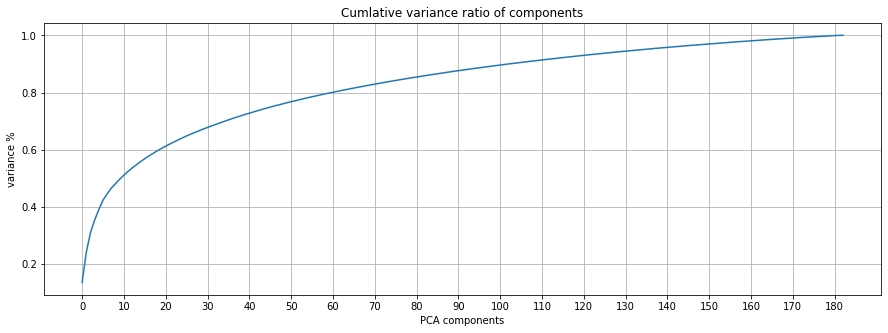

In [264]:
plt.figure(figsize=(15,5))
plt.plot(range(pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCA components')
plt.ylabel('variance %')
plt.xticks(range(0,pca.n_components_,10))
plt.title('Cumlative variance ratio of components')
plt.grid()
plt.show()

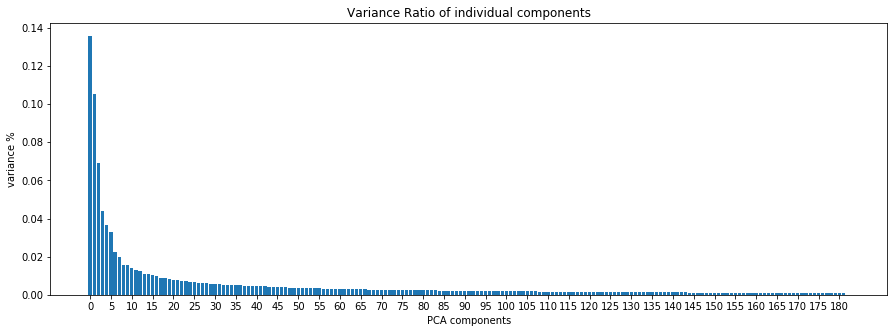

In [265]:
plt.figure(figsize=(15,5))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA components')
plt.ylabel('variance %')
plt.xticks(range(0,pca.n_components_,5))
plt.title('Variance Ratio of individual components')
plt.show()

**Taking 60 components as they cover 80% of the variance (as determined from the plots above)**

In [266]:
# applying PCA to 60 components 
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
print(X_pca.shape)

(183, 60)


In [267]:
X_pca.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,24.20290,-16.856010,2.266715,-22.099590,19.578857,-17.332624,11.393803,-8.529557,14.633904,-21.969297,-11.374313,-9.073893,-12.724087,-3.397808,12.994495,-6.061602,9.439876,10.296375,1.295877,2.203924,18.420809,-5.036620,0.848397,-12.995984,-9.047802,-1.892735,0.681080,15.428516,-0.478489,2.257378,-5.506546,-7.068084,5.155587,12.843649,10.018503,-9.345473,9.573237,-5.029055,-2.651342,-6.283941,5.542130,-0.815076,-1.123285,-1.722491,2.547158,-13.511759,-0.411739,-7.496311,1.504895,-10.541015,0.617718,0.425360,5.726555,3.204777,-2.736091,4.588910,5.130791,-1.827435,5.374151,-3.148327
1,4.75422,-14.106684,3.110060,-23.292856,4.592645,-28.306992,-2.647141,-0.995478,-8.332380,-15.914499,-8.901006,-6.562006,8.929822,-3.651225,-17.383112,25.829855,18.427311,-11.751341,14.112494,-8.426990,9.946938,-4.182847,0.236147,-0.607623,-10.559087,-13.763225,-21.492168,-8.821611,6.748864,-2.606222,-3.106671,2.123481,-0.648232,6.100066,9.518477,-1.099739,-4.102399,10.779792,8.220078,1.135979,0.412493,-9.723706,-8.031657,0.970866,-1.782442,-2.789357,4.545248,0.497861,-3.724381,-0.846492,10.149482,-2.515293,-3.614027,-2.973463,-7.934254,-4.819015,-2.329142,0.426465,5.223714,-0.277823


Green: Adenocarcinoma and Red: Neuroendocrine


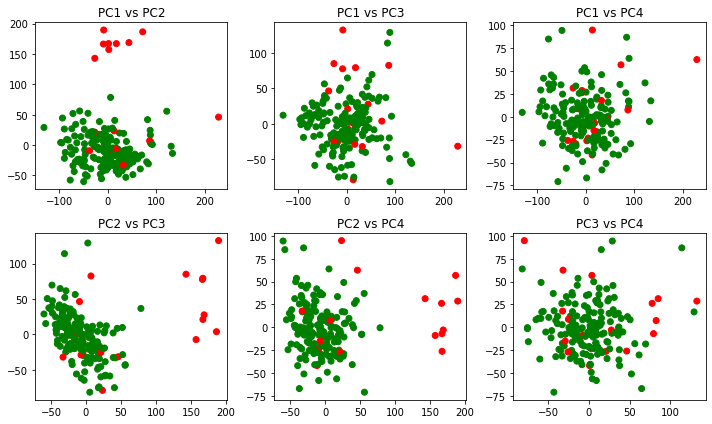

In [273]:
# plotting first 2 principal components
#plt.figure(figsize=(6,6))
pcs = [0,1,2,3]
color = ['red' if i=='neuroendocrine' else 'green' for i in df['histological_type']]
print("Green: Adenocarcinoma and Red: Neuroendocrine")
comb = combinations(pcs,2)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
for row in ax:
  for col in row:
    x,y = next(comb)
    col.scatter(X_pca[x], X_pca[y], c=color)
    col.set_title(f'PC{x+1} vs PC{y+1}')
fig.tight_layout()
plt.show()

**Two clusters are clearly visible in:**

* PC1 vs PC2  
* PC2 vs PC3
* PC2 vs PC4

### **Q.** What does the analysis say about the general behaviour of the different samples?
**Most of the similar samples are close together in their own cluster, but there is some noise in some of the samples (specially the neuroendocrine ones).**
### **Q.** Are the neuroendocrine tumors clearly separable from the adenocarcinoma tumors?
**Most of the neuroendocrine samples are clearly separable from adenocarcinoma, but there are a few samples which are not. This might be due to the cleaning process that I took without much background knowledge**
### **Q.** What can be said about the variance of the PCA?
**80% of the variance is captured by only 60 prinicipal components.**

In [283]:
#removing neuroendocrine samples from data
df = df[df['histological_type']=='adenocarcinoma']
df.drop(['histological_type'],axis=1, inplace=True)
print(df.shape)

(165, 18465)


In [281]:
with open(f'{path}type1_IFN.txt', 'r') as f:
  type1_inf = f.read()
type1_inf = type1_inf.split('\n')[:-1]
len(type1_inf)

25

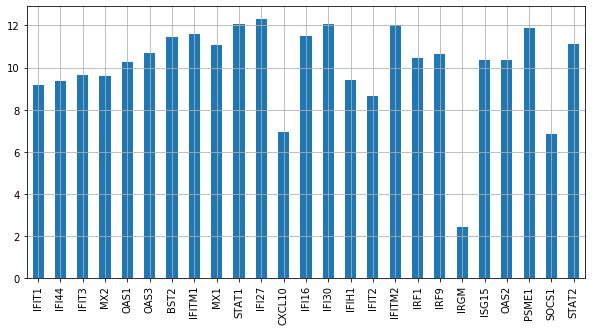

In [289]:
# plotting the mean values of Type1 IFN genes
df[type1_inf].mean(axis=0).plot(kind='bar', figsize=(10,5), grid=True)

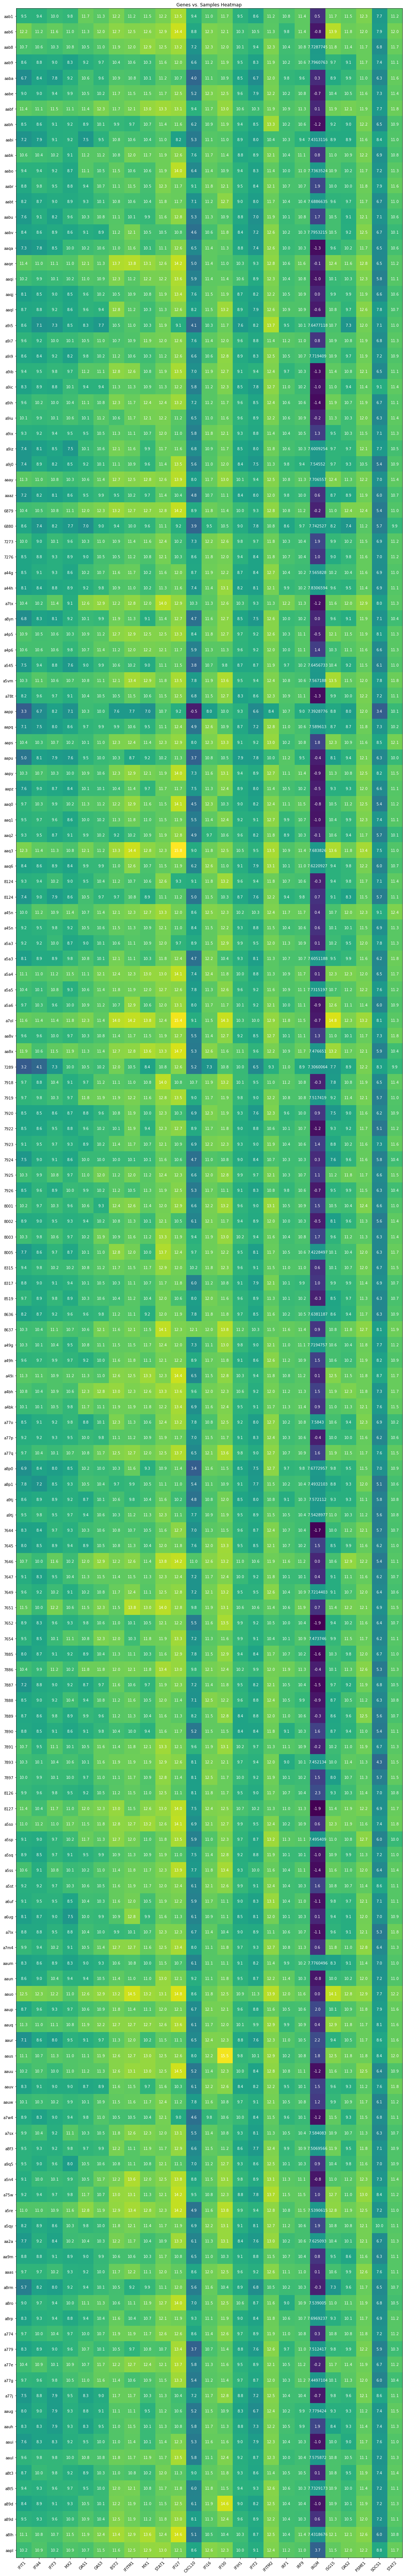

In [313]:
#plotting heatmap
idx = list(map(lambda x: x[:4], df.index.astype(str)))
fig, ax = plt.subplots(figsize=(15,100))
im = ax.imshow(df[type1_inf].values)

ax.set_xticks(np.arange(len(type1_inf)))
ax.set_yticks(np.arange(len(idx)))

ax.set_xticklabels(type1_inf)
ax.set_yticklabels(idx)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(idx)):
    for j in range(len(type1_inf)):
        text = ax.text(j, i, df[type1_inf].values[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Genes vs. Samples Heatmap")
fig.tight_layout()
plt.show()

In [0]:
from GSVA import gsva
from scipy.stats import norm 

### **Q.** Can you plot the gene expression values for these genes for pancreatic adenocarcinoma?
**Yes, I have plotted the mean values of the necessary genes and also a heatmap.**

### **Q.** Can you characterize the presence of IFN signature in pancreatic adenocarcinoma tumors by assigning a score to each sample which denotes the positive or negative presence of IFN genes in the sample?
**Yes, that can be done using the GSVA method.**

### **Q.** How is the distribution of this score among the different samples?

### **Q.** Based on this distribution can we identify the presence of high and low IFN subtypes in PAAD